<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [82]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [ ]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

### Load Data From CSV File  

In [83]:
df = pd.read_csv(r'C:\Users\Brad\Documents\Coursera\loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.shape

(346, 10)

### Convert to date time object 

In [84]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [ ]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

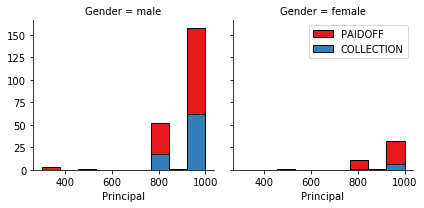

In [85]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

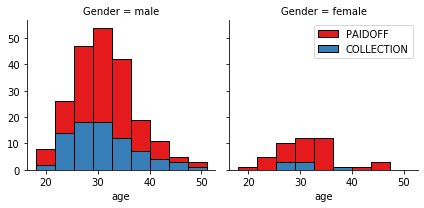

In [86]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

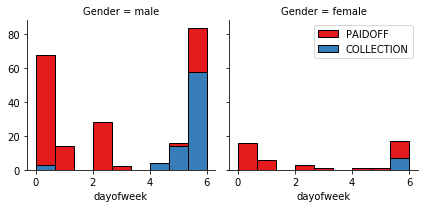

In [87]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [88]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [89]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [90]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [91]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [92]:
Feature = df[['Principal','terms','age','Gender','weekend','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,0,3,0,1,0
1,1000,30,33,1,0,3,1,0,0
2,1000,15,27,0,0,3,0,0,1
3,1000,30,28,1,1,4,0,0,1
4,1000,30,29,0,1,4,0,0,1


### Feature selection

Lets defind feature sets, X:

In [93]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,0,3,0,1,0
1,1000,30,33,1,0,3,1,0,0
2,1000,15,27,0,0,3,0,0,1
3,1000,30,28,1,1,4,0,0,1
4,1000,30,29,0,1,4,0,0,1


What are our lables?

In [94]:
y = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [95]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.26, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21, -0.26,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.26, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83,  0.12, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83,  0.12, -0.38, -0.88,  1.15]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

## Train Test Split
Out of Sample Accuracy is the percentage of correct predictions that the model makes on data that that the model has NOT been trained on. Doing a train and test on the same dataset will most likely have low out-of-sample accuracy, due to the likelihood of being over-fit.

It is important that our models have a high, out-of-sample accuracy, because the purpose of any model, of course, is to make correct predictions on unknown data. So how can we improve out-of-sample accuracy? One way is to use an evaluation approach called Train/Test Split. Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set.

This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the data. It is more realistic for real world problems.

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 9) (276,)
Test set: (70, 9) (70,)


## Classification

### K nearest neighbor (KNN)

#### Import Library

Classifier implementing the k-nearest neighbors vote.

In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

### Training

Lets start the algorithm with k=4 for now:

In [98]:
k = 7
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

### Predicting
we can use the model to predict the test set:

In [99]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

### Accuracy evaluation
In multilabel classification, __accuracy classification score__ is a function that computes subset accuracy. This function is equal to the jaccard_similarity_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.

In [103]:
from sklearn import metrics
knn_y_test = y_test
knn_yhat = yhat
knn_cr = classification_report(y_test, yhat)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print(knn_cr)

Train set Accuracy:  0.8007246376811594
Test set Accuracy:  0.7285714285714285
              precision    recall  f1-score   support

           0       0.83      0.82      0.83        55
           1       0.38      0.40      0.39        15

    accuracy                           0.73        70
   macro avg       0.60      0.61      0.61        70
weighted avg       0.74      0.73      0.73        70



In [23]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.77142857, 0.71428571, 0.74285714, 0.72857143,
       0.75714286, 0.72857143, 0.74285714, 0.7       ])

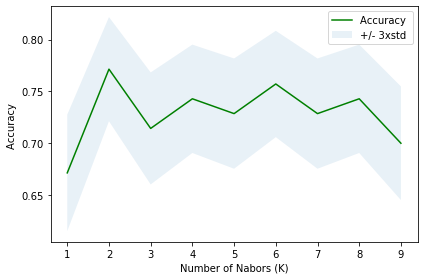

Best accuracy: 0.7714285714285715 k= 2


In [24]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "Best accuracy:", mean_acc.max(), "k=", mean_acc.argmax()+1)

# Decision Tree

In [104]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [26]:
!conda install -c conda-forge pydotplus -y

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.6.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda




In [27]:
!conda install -c conda-forge python-graphviz -y

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.6.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda




In [105]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree # it shows the default parameters

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [106]:
loanTree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [107]:
predTree = loanTree.predict(X_test)

In [108]:
print (predTree [0:5])
print (y_test [0:5])

[0 0 0 0 0]
[0 0 0 0 0]


In [109]:
from sklearn import metrics
import matplotlib.pyplot as plt
dt_y_test = y_test
dt_predTree = predTree
dt_cr = classification_report(y_test, yhat)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))
print(dt_cr)

DecisionTrees's Accuracy:  0.7857142857142857
              precision    recall  f1-score   support

           0       0.83      0.82      0.83        55
           1       0.38      0.40      0.39        15

    accuracy                           0.73        70
   macro avg       0.60      0.61      0.61        70
weighted avg       0.74      0.73      0.73        70



# Support Vector Machine

In [110]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [111]:
yhat = clf.predict(X_test)
yhat [0:5]

array([1, 0, 0, 0, 0], dtype=int64)

In [112]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [113]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        55
           1       0.36      0.27      0.31        15

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[48  7]
 [11  4]]


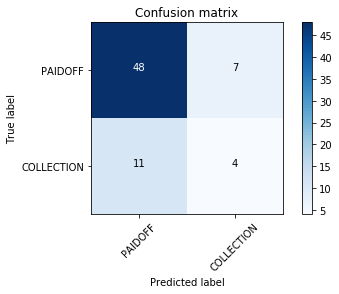

In [114]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [115]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.7275882012724117

In [116]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

C:\Users\Brad\.conda\envs\NLP_3.7\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.7428571428571429

In [52]:
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat2))

Avg F1-score: 0.6914
Jaccard score: 0.7857


C:\Users\Brad\.conda\envs\NLP_3.7\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [53]:
clf3 = svm.SVC(kernel='poly')
clf3.fit(X_train, y_train) 
yhat3 = clf3.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat3, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat3))

Avg F1-score: 0.7065
Jaccard score: 0.7714


C:\Users\Brad\.conda\envs\NLP_3.7\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [54]:
clf4 = svm.SVC(kernel='sigmoid')
clf4.fit(X_train, y_train) 
yhat4 = clf4.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat4, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat4))

Avg F1-score: 0.6954
Jaccard score: 0.7286


C:\Users\Brad\.conda\envs\NLP_3.7\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [118]:
svm_y_test = y_test
svm_yhat = yhat
svm_cr = classification_report(y_test, yhat)
print(svm_cr)

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        55
           1       0.36      0.27      0.31        15

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70



# Logistic Regression

Leveraging the 'df' dataframe that was cleaned in the preprocessing steps above.

In [55]:
df

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
341,394,394,COLLECTION,800,15,2016-09-11,2016-09-25,32,High School or Below,0,6,1
342,395,395,COLLECTION,1000,30,2016-09-11,2016-10-10,25,High School or Below,0,6,1
343,397,397,COLLECTION,800,15,2016-09-12,2016-09-26,39,college,0,0,0
344,398,398,COLLECTION,1000,30,2016-09-12,2016-11-10,28,college,0,0,0


### Feature Selection

In [119]:
FeatureLR = df[['Principal','terms','age','Gender','weekend','loan_status']]
FeatureLR = pd.concat([FeatureLR,
                     pd.get_dummies(df['education']),
                     pd.get_dummies(df['loan_status'])]
                     , axis=1)
FeatureLR.drop(['Master or Above'], axis = 1,inplace=True)
FeatureLR.drop(['loan_status'], axis = 1,inplace=True)
FeatureLR.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college,COLLECTION,PAIDOFF
0,1000,30,45,0,0,0,1,0,0,1
1,1000,30,33,1,0,1,0,0,0,1
2,1000,15,27,0,0,0,0,1,0,1
3,1000,30,28,1,1,0,0,1,0,1
4,1000,30,29,0,1,0,0,1,0,1


Aligning data points to int64 datatype

In [120]:
FeatureLR.dtypes
FeatureLR['Bechalor'] = FeatureLR['Bechalor'].astype('int64')
FeatureLR['High School or Below'] = FeatureLR['High School or Below'].astype('int64')
FeatureLR['college'] = FeatureLR['college'].astype('int64')
FeatureLR['COLLECTION'] = FeatureLR['COLLECTION'].astype('int64')
FeatureLR['PAIDOFF'] = FeatureLR['PAIDOFF'].astype('int64')

In [121]:
FeatureLR.dtypes

Principal               int64
terms                   int64
age                     int64
Gender                  int64
weekend                 int64
Bechalor                int64
High School or Below    int64
college                 int64
COLLECTION              int64
PAIDOFF                 int64
dtype: object

Converting df to numpy array

In [122]:
X = np.asarray(FeatureLR[['Principal','terms','age','Gender','weekend']])
X[0:5]

array([[1000,   30,   45,    0,    0],
       [1000,   30,   33,    1,    0],
       [1000,   15,   27,    0,    0],
       [1000,   30,   28,    1,    1],
       [1000,   30,   29,    0,    1]], dtype=int64)

Two variables were created from the loan status field, dropping PAIDOFF as we only need one variable for y

In [123]:
y=np.asarray(FeatureLR['COLLECTION'])
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Scaling

In [124]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21],
       [ 0.52,  0.92,  0.34,  2.38, -1.21],
       [ 0.52, -0.96, -0.65, -0.42, -1.21],
       [ 0.52,  0.92, -0.49,  2.38,  0.83],
       [ 0.52,  0.92, -0.32, -0.42,  0.83]])

### Train Test Split

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 5) (276,)
Test set: (70, 5) (70,)


Inspecting sets

In [126]:
print("X_train: ", X_train.shape)
print(X_train[:5])
print("X_test: ", X_test.shape)
print(X_test[:5])
print("y_train: ", y_train.shape)
print(y_train[:5])
print("y_test: ", y_test.shape)
print(y_test[:5])

X_train:  (276, 5)
[[ 0.52 -0.96  0.67 -0.42 -1.21]
 [ 0.52  0.92 -0.82 -0.42  0.83]
 [ 0.52  0.92  0.01 -0.42 -1.21]
 [ 0.52 -0.96 -0.98 -0.42  0.83]
 [ 0.52  0.92 -0.49 -0.42 -1.21]]
X_test:  (70, 5)
[[ 0.52  0.92 -0.16 -0.42  0.83]
 [-1.31 -0.96 -0.16 -0.42  0.83]
 [ 0.52 -0.96  0.01 -0.42 -1.21]
 [ 0.52  0.92 -1.15 -0.42 -1.21]
 [ 0.52  0.92  0.51 -0.42 -1.21]]
y_train:  (276,)
[0 1 0 0 0]
y_test:  (70,)
[0 0 0 0 0]


Initiatlizing a Logistic Regresssion object and fitting to training sets

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [128]:
yhat = LR.predict(X_test)
yhat[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [129]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob[0:5]

array([[0.5 , 0.5 ],
       [0.55, 0.45],
       [0.7 , 0.3 ],
       [0.66, 0.34],
       [0.68, 0.32]])

### Evaluation

jaccard index

In [130]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

C:\Users\Brad\.conda\envs\NLP_3.7\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.6857142857142857

### Confusion Matrix

In [131]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 2 13]
 [ 9 46]]


Confusion matrix, without normalization
[[ 2 13]
 [ 9 46]]


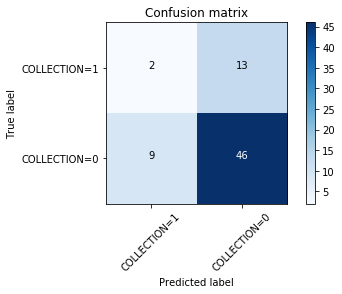

In [132]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION=1','COLLECTION=0'],normalize= False,  title='Confusion matrix')

In [134]:
lr_y_test = y_test
lr_yhat = yhat
lr_cr = classification_report(y_test, yhat)
print(lr_cr)

              precision    recall  f1-score   support

           0       0.78      0.84      0.81        55
           1       0.18      0.13      0.15        15

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70



### Compute Log Loss

In [71]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.5772816209870316

# Model Evaluation using Test set

In [72]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [74]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-02-12 09:45:06--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: 'loan_test.csv'

     0K ...                                                   100% 20.7M=0s

2020-02-12 09:45:06 (20.7 MB/s) - 'loan_test.csv' saved [3642/3642]



### Load Test set for evaluation 

In [147]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [148]:
#convert gender to int64
test_df['Gender'].replace(to_replace=['male','female'], value=[np.int64(0),np.int64(1)],inplace=True)
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
#Build feature set from test data
Feature = test_df[['Principal','terms','age','Gender']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,Bechalor,High School or Below,college
0,1000,30,50,1,1,0,0
1,300,7,35,0,0,0,0
2,1000,30,43,1,0,1,0
3,1000,30,26,0,0,0,1
4,800,15,29,0,1,0,0


In [150]:
X2 = Feature
y2 = test_df['loan_status'].values
X2= preprocessing.StandardScaler().fit(X2).transform(X2)

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

In [144]:
knn_test_cr = classification_report(y_test, knn_yhat)
print(knn_test_cr)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83        55
           1       0.38      0.40      0.39        15

    accuracy                           0.73        70
   macro avg       0.60      0.61      0.61        70
weighted avg       0.74      0.73      0.73        70



In [143]:
dt_test_cr = classification_report(y_test, dt_predTree)
print(dt_test_cr)

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        55
           1       0.00      0.00      0.00        15

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70



C:\Users\Brad\.conda\envs\NLP_3.7\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [142]:
svm_test_cr = classification_report(y_test, svm_yhat)
print(svm_test_cr)

              precision    recall  f1-score   support

           0       0.78      0.84      0.81        55
           1       0.18      0.13      0.15        15

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70



In [145]:
lr_test_cr = classification_report(y_test, lr_yhat)
print(lr_test_cr)

              precision    recall  f1-score   support

           0       0.78      0.84      0.81        55
           1       0.18      0.13      0.15        15

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70



### Report Metrics Output:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.73    | 0.73     | NA      |
| Decision Tree      | 0.79    | 0.69     | NA      |
| SVM                | 0.69    | 0.67     | NA      |
| LogisticRegression | 0.69    | 0.67     | 0.57    |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>